<a href="https://colab.research.google.com/github/VIGNESHinZONE/Beginners-level-ML-projects/blob/master/Writing_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 33: Physics Informed Neural Networks using JaxModel & PINN_Model
 - [Vignesh Venkataraman](https://github.com/VIGNESHinZONE)


## Contents

- Physics Informed Neural Networks
- Setup
- Brief about Jax and Autodiff
- Burger's Equation
- Data Visualisation
- Explanation of the Solution using Jax
- Usage of PINN Model
- Visualize the final results

#Physics Informed Neural Networks

PINNs was introduced by Maziar Raissi et. al in their paper [Physics Informed Deep Learning (Part I): Data-driven
Solutions of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10561) which are used for solving supervised learning tasks and also follow an underlying differential equation derived from understanding the Physics. In more simple terms, we try solving a differential equation with a neural network and using the differential equation as the regulariser in the loss function.

<br>

---

### Here is an illustration of PINNs using a simple differential equation-


$\quad \quad \quad \frac{df}{dt} = f(u, t), \quad  $ where initial condition is $\ \ u(t=0) = u_0$

<br>


We approximate function $u(t)$ using a Neural Network as $NN(t)$ and apply the following loss function - 

<br>


  Initial Loss: $\quad  L_0 = (NN(t=0) - u_0)^2$

  Regulariser Loss:= $\quad L_r = | \frac{d NN (t) }{d t} - f(NN(t), t) |$

<br>


And we minimise the $Total Loss$ using Backpropagation-

<br>


  Total Loss = Initial Loss + Regulariser Loss

<br>


### Here is a technical definition of PINNs taken from the author's official blog-

  $\quad \quad u_t + \mathcal{N}[u] = 0,\ x \in \Omega, \ t\in[0,T],$

<br>


where $\ u(t,x) \ $ denotes the latent (hidden) solution, $\ N[⋅] \ $ is a nonlinear differential operator, and $Ω$ is a subset of $\ \mathbb{R}^D \ $ , and proceed by approximating $u(t,x)$ by a deep neural network. We define $\ f(t,x) \ $ to be given by

<br>
 
  $\quad \quad f := u_t + \mathcal{N}[u],$

<br>

This assumption results in a physics informed neural network $ \ f(t,x) \ $. This network can be derived by the calculus on computational graphs: Backpropagation.

<br>

---

### Useful Resources to learn more about PINNs


- [Maziar Raissi et. al. official blog on PINNs](https://maziarraissi.github.io/PINNs/)
- [Chris Rackauckas's lecture on PINNs lecture 3](https://github.com/mitmath/18337#lecture-3-introduction-to-scientific-machine-learning-through-physics-informed-neural-networks): these lectures are in Julia programming language but still are a great source of learning.

# Setup


In [ ]:
### In case if you are running this notebook in Local Machine and have CUDA installed then uncomment this below line. ###
### Change the cuda version depending on your setup. Here Cuda 11.x is represented as `cuda111`
# !pip install --upgrade pip
# !pip install --upgrade "jax[cuda111]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install deepchem[jax]
!pip install pyDOE

     |████████████████████████████████| 552 kB 5.4 MB/s 
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=4da795f38a3c13631115b175ca51b0cca2ebc9226d122d2f90ddf4975609baaf
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
import deepchem as dc
import os

PINNs_URL = "https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/raissi_pinns_data.tar.gz"
dc.utils.data_utils.download_url(
    url=PINNs_URL, dest_dir=os.getcwd())
targz_file = os.path.join(os.getcwd(), 'raissi_pinns_data.tar.gz')
dc.utils.data_utils.untargz_file(targz_file, os.getcwd())



# Brief about Jax and Autodiff

- Mention the usage of jax and its functional style
- Mention about the Autodiff cookbook from Jax
- Asking them to take a look at Haiku and optax library
- About the JaxModel and PINN_Model superclass

Deepchem has recently introduced Jax support for building models and `JaxModel` superclass is the main API for building 

# Burgers Equation

Burgers’ equation is a partial differential equation that was originally proposed as a simplified model of turbulence as exhibited by the full-fledged Navier-Stokes equations. It is a nonlinear equation for which exact solutions are known and is therefore important as a benchmark problem for numerical methods. [More Refrence](https://www.azimuthproject.org/azimuth/show/Burgers%27+equation)

<br>

Here is the differential Equation we are trying to solve

  $\begin{array}{l}
  \ \ \ u_t + u u_x - (0.01/\pi) u_{xx} = 0,\ \ \ x \in [-1,1],\ \ \ t \in [0,1]
  \end{array}$

<br>

Here are the initial conditions

  $\ \ \ u(x, 0) = -\sin(\pi x),$

  $\ \ \ u(-1, t) = u(1, t) = 0.0$

<br>

Now let us define:

  $
  \ \ \ f := u_t + u u_x - (0.01/\pi) u_{xx},
  $

and we approximate $u(x, t)$ using Neural Network as $NN(\theta, x, t)$ where $\theta$ are the weights of neural networks 

<br>

---

</br>
Now here are the three main data points that will be used for training our Neural Network to approximate $u(x,t)$



1.   We will train points lying between $x \in [-1,1]$ and $t=0$ to follow as part of the L2 Loss

    $min\ \ _\theta \ \ (NN(\theta, x, t) + \sin(\pi x))^2$

<br>


2.   We will train points lying between $t \in [0,1]$ and $x= \pm1 $ as part of the L2 Loss

    $min\ \ _\theta \ \ (NN(\theta, x, t) + \sin(\pi x))^2$

<br>

3.   We will train points lying between $x \in [-1,1],\ \ \ t \in [0,1]$ as part of the regulariser loss

    $f(\theta, x, t):= \ \ \frac{\partial NN(\theta, x, t)}{\partial t} + NN(\theta, x, t)\frac{\partial NN(\theta, x, t)}{\partial x} - (0.01/\pi)\frac{\partial^2 NN(\theta, x, t)}{\partial^2 x} $

    $min\ \ _\theta \ \ f(\theta, x, t)$

</br>

In this tutorial, we will be combing data conditions 1 and 2 under the same L2Loss

# Data Visualisation of the Burgers Equation

Now lets load the Burger's Data provided from the author. `pre_process_shock_data ` is used to load the data in a format suitable for Neural Networks. Understanding this function is not neccesary for working through the tutorials.


In [ ]:
## Data Preprocessing

# Create Dataset

import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import numpy as np
import random
random.seed(0)
np.random.seed(0)

def pre_process_shock_data(data):

  N_u = 100
  N_f = 10000

  t = data['t'].flatten()[:,None]
  x = data['x'].flatten()[:,None]
  Exact = np.real(data['usol']).T

  X, T = np.meshgrid(x,t)

  X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
  u_star = Exact.flatten()[:,None]              

  # Doman bounds
  lb = X_star.min(0)
  ub = X_star.max(0)    

  xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
  uu1 = Exact[0:1,:].T
  xx2 = np.hstack((X[:,0:1], T[:,0:1]))
  uu2 = Exact[:,0:1]
  xx3 = np.hstack((X[:,-1:], T[:,-1:]))
  uu3 = Exact[:,-1:]

  X_u_train = np.vstack([xx1, xx2, xx3])
  X_f_train = lb + (ub-lb)*lhs(2, N_f)
  X_f_train = np.vstack((X_f_train, X_u_train))
  u_train = np.vstack([uu1, uu2, uu3])

  idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
  X_u_train = X_u_train[idx, :]
  u_train = u_train[idx,:]
  return X_u_train, u_train, X_f_train, X_star

mat_data = scipy.io.loadmat(os.path.join(os.getcwd(), 'PINNs/burgers_shock.mat'))
labeled_X, labeled_y, unlabeled_X, full_domain = pre_process_shock_data(mat_data)

We have three Numpy arrays `labeled_X`, `labeled_y` and `unlabeled_X` which will be used for training our neural network,

1) `labeled_X` consists of  $x \in [-1,1]$ & $t=0$ and $t \in [0,1]$ & $x= \pm1 $. `labeled_y` has the value of $u(x, t)$:

Let us verify that `labeled_X` & `labeled_y` also consists of data points satisfying the condition of 

  $\ \ \ u(x, 0) = -\sin(\pi x), \quad \quad x \in [-1,1]$ & $t=0$



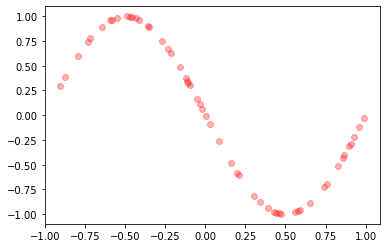

In [ ]:
import matplotlib.pyplot as plt
ind = labeled_X[:, 1] == 0.0
print(f"Number of Datapoints with with t = 0 is {len(labeled_X[labeled_X[:, 1] == 0.0])}")
plt.scatter(labeled_X[ind][:, 0], labeled_y[ind], color = 'red', marker = "o", alpha = 0.3)




Let us verify that at `labeled_X` & `labeled_y` also consists of datapoints satisfying the condition of 

  $\ \ \ u(-1, t) = u(1, t) = 0.0, \quad \quad t \in [0,1]$ & $x= \pm1$


In [ ]:
ind = np.abs(labeled_X[:, 0]) == 1.0
print(f"Number of Datapoints with with |x| = 1 is {len(labeled_X[np.abs(labeled_X[:, 0]) == 1.0])}")
np.max(labeled_y[ind]), np.min(labeled_y[ind]), np.mean(labeled_y[ind])


(2.326502818752141e-16, -1.0854441803149965e-16, 8.236830416577723e-17)

# Explanation of the solution

We will be using Deepchem's `PINNModel` class to solve Burger's Equation which is based out of `Jax` library. We will approximate $u(x, t)$ using a Neural Network represented as $NN(\theta, x, t)$

For our purpose, we will be using the Haiku library for building neural networks. Due to the functional nature of Jax, we define neural network with two things

- Parameters - which act as the weight matrices, upon which Backpropagation is applied for optimisation.
- forward_fn - This defines how the weights are used for computing the outputs. Ex- Feedforward, Convolution, etc




In [ ]:
import jax
import jax.numpy as jnp
import haiku as hk

def f(x, y, z, t):
  x = jnp.hstack([x, t])
  net = hk.nets.MLP(output_sizes = [20, 20, 20, 20, 20, 20, 20, 20, 1],
                    activation = jnp.tanh)
  return net(x)

init_params, forward_fn = hk.transform(f)
rng = jax.random.PRNGKey(500)
x_init, t_init = jnp.split(X_u_train, 2, 1)
params = init_params(rng, x_init, t_init)


As per the docstrings of PINNModel, we require two additional functions in the given format - 

1. Create a gradient_fn which tells us about how to compute the gradients of the function-
```
  >>>
  >> def gradient_fn(forward_fn, loss_outputs, initial_data):
  >>  def model_loss(params, target, weights, rng, ...):
  >>    # write code using the arguments.
  >>    # ... indicates the variable number of positional arguments.
  >>    return
  >>  return model_loss
```

And to understand more about PINNModel, you can see that the same gradient_fn gets called in the code for computing the gradients.

For our purpose, we have two variables $(x, t)$ and we need to tell the PINN Model how to compute the final gradient. For carrying out this process we will be using these main features from jax library for calculating the loss - 

1. [vmap](https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html) - This for parallelising computations in batches. We will process each row of the dataset, but it will get batched automatically using this feature. 
2. [jacrev](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev) - This is used to calculate the jacobian matrix. In our case, the output is a single dimension and hence it can be thought of as the gradient function. We could directly use jax's [grad](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html?highlight=grad#jax-first-transformation-grad) function but using `jacrev` simplifies the array shapes and hence is easier.


We need to compute two losses for solving our differential equation-

1. Initial Loss

```
u_pred = forward_fn(params, rng, x_b, t_b)
initial_loss = jnp.mean((u_pred - boundary_target) ** 2)
```

2. Regulariser Loss

This is slightly complicated as we need to compute 

$f(\theta, x, t):= \ \ \frac{\partial NN(\theta, x, t)}{\partial t} + NN(\theta, x, t)\frac{\partial NN(\theta, x, t)}{\partial x} - (0.01/\pi)\frac{\partial^2 NN(\theta, x, t)}{\partial^2 x} $

The partial derivative operation in the first and second terms can be calculated using `jacrev` function-
```
u_x, u_t = jacrev(forward_fn, argnums=(2, 3))(params, rng, x, t)
```

The second partial derivative operation in the third term can be applying `jacrev` twice-

```
u_xx = jacrev(jacrev(forward_fn, argnums=2), argnums=2)(params, rng, x, t)
```


In [ ]:
from jax import jit, vmap, jacrev

def gradient_fn(forward_fn, loss_outputs, initial_data):
  """
  This function calls the gradient function, to implement the backpropogation
  """
  boundary_data_x = initial_data['labeled_x']
  boundary_data_t = initial_data['labeled_t']

  boundary_target = initial_data['labeled_u']

  @jax.jit
  def model_loss(params, target, weights, rng, x_train, t_train):

    @functools.partial(jax.vmap, in_axes=(None, 0, 0))
    def small_loss(params, x, t):
      u = forward_fn(params, rng, x, t)
      u_x, u_t = jacrev(forward_fn, argnums=(2, 3))(params, rng, x, y, z, t)
      u_xx = jacrev(jacrev(forward_fn, argnums=2), argnums=2)(params, rng, x, t)
      con = 0.01/np.pi
      return u_t + u * u_x - con * u_xx

    u_pred = forward_fn(params, rng, boundary_data_x, boundary_data_t)
    f_pred = small_loss(params, x_train, t_train)
    loss_u = jnp.mean((u_pred - boundary_target) ** 2)
    loss_f = jnp.mean((f_pred) ** 2)

    return loss_u + loss_f

  return model_loss



2. We also need to provide an eval_fn in the below-given format for computing the weights
```
  >>>
  >> def create_eval_fn(forward_fn, params):
  >>  def eval_model(..., rng=None):
  >>    # write code here using arguments
  >>
  >>    return
  >>  return eval_model
```

Like previously we have two arguments for our model $(x, t)$ which get passed in function

In [ ]:
# Tells the neural network on how to perform calculation during inference
def create_eval_fn(forward_fn, params):
  """
  Calls the function to evaluate the model
  """
  @jax.jit
  def eval_model(x, t, rng=None):

    res = forward_fn(params, rng, x, t)
    return jnp.squeeze(res)
  return eval_model


# Usage of PINN Model

We will be using optax library for performing the optimisations. PINNModel executes the codes for training the models.

In [ ]:
import optax
scheduler = optax.piecewise_constant_schedule(
    init_value=1e-2, 
    boundaries_and_scales={5000: 0.1, 10000: 0.1, 15000: 0.1})

opt = optax.chain(
    optax.clip_by_global_norm(1.00),
    optax.scale_by_adam(b1=0.9, b2=0.99),
    optax.scale_by_schedule(scheduler),
    optax.scale(-1.0))

labeled_x, labeled_t = jnp.split(labeled_X, 2, 1)

boundary_data = {
    'labeled_x': labeled_x, 'labeled_t':labeled_t, 'labeled_u': labeled_y
}

  boundary_data_x = initial_data['labeled_x']
  boundary_data_t = initial_data['labeled_t']

  boundary_target = initial_data['labeled_u']

j_m = PINN_Model(      
    forward_fn = forward_fn,
    params = params,
    boundary_data = boundary_data,
    batch_size = 1000,
    optimizer = opt,
    grad_fn = gradient_fn,
    eval_fn = create_eval_fn,
    deterministic = True,
    log_frequency = 1000
    )

dataset = dc.data.NumpyDataset(unlabeled_X)
val = j_m.fit(dataset, nb_epochs=4000)


# Visualize the final results

- Code taken from authors for visualisation
- show both graphs

In [ ]:
test_dataset = dc.data.NumpyDataset(full_domain)
u_pred = j_m.predict(test_dataset)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

